**Определение аналогов и дубликатов на складе с помощью нейросети**

In [75]:
# Подгружаем гугл-диск
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [76]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras.optimizers import Adam # 
from tensorflow.keras.preprocessing.text import Tokenizer
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import LSTM, GRU, SimpleRNN, Bidirectional, Reshape, Concatenate

from tensorflow.keras.optimizers import Adam # 
from tensorflow.keras import utils # Для работы с категориальными данными
from tensorflow.keras.models import Sequential, Model # Полносвязная модель
from tensorflow.keras.layers import Dense, Dropout, SpatialDropout1D, BatchNormalization, Embedding, Flatten, Activation, Input, concatenate # Слои для сети
from tensorflow.keras.preprocessing.text import Tokenizer # Методы для работы с текстами и преобразования их в последовательности
from tensorflow.keras.preprocessing.sequence import pad_sequences # Метод для работы с последовательностями
 
from sklearn.preprocessing import LabelEncoder # Метод кодирования тестовых лейблов
from sklearn.model_selection import train_test_split # Для разделения выборки на тестовую и обучающую
from google.colab import drive # Для работы с Google Drive
import time # Импортируем библиотеку time
from scipy.stats import mode
import time

# Статический вывод графики (графики отображаются в той ячейке, в которой используется plt.show())
%matplotlib inline

**ПОДГОТОВКА БАЗЫ**

In [77]:
warehouse = pd.read_csv ("/content/drive/MyDrive/Analog&duplicat/SpareParts2.csv", sep = '\t')#Загружаем csv-файл с данными


In [78]:
warehouse.head(10)#Проверяем загрузку по 10 первым строкам

,Material,Short text,SKF,FAG,SNR,KOYO,EZO,NTN,NSK,RHP,ROLLWAY,TIMKEN,INA,Unnamed: 13,Unnamed: 14
0,100247567,Подшипник 52206,NaN,NaN,NaN,Подшипник KOYO 52206,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,100260213,Подшипник 3206,NaN,NaN,NaN,Подшипник KOYO 3206,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,100301277,Подшипник K16х22х12,NaN,NaN,NaN,Подшипник KOYO K16х22х12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,100301278,Подшипник K55х63х20,NaN,NaN,NaN,Подшипник KOYO K55х63х20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,100301279,Подшипник RNA4903,NaN,NaN,NaN,Подшипник KOYO RNA4903,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,100301360,Подшипник 6406,Подшипник SKF 6406,Подшипник FAG 6406,Подшипник SNR 6406,Подшипник KOYO 6406,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,100301361,Подшипник 6201-2Z,NaN,NaN,NaN,Подшипник KOYO 6201-2Z,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,100301362,Подшипник 6407,Подшипник SKF 6407,Подшипник FAG 6407,Подшипник SNR 6407,Подшипник KOYO 6407,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,100301363,Подшипник NA2020,NaN,NaN,NaN,Подшипник KOYO NA2020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,100301364,Подшипник NA4913,NaN,NaN,NaN,Подшипник KOYO NA4913,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [79]:
print(warehouse.shape)#Печатаем струкуру массива (количество строк: 663, столбцов: 15)

(663, 15)


In [80]:
warehouse.fillna('$', inplace=True) #Переименовываем NaN в "$"

In [81]:
warehouse = warehouse.astype(str).apply(lambda x: x.str.lower())#Преобразовываем наш DataFrame к нижнему регистру

In [82]:
warehouse.drop(['Unnamed: 13','Unnamed: 14'], axis =1, inplace=True) # Убираем 13, 14-е столбцы. Они нам не нужны

In [83]:
warehouse.head(10)

,Material,Short text,SKF,FAG,SNR,KOYO,EZO,NTN,NSK,RHP,ROLLWAY,TIMKEN,INA
0,100247567,подшипник 52206,$,$,$,подшипник koyo 52206,$,$,$,$,$,$,$
1,100260213,подшипник 3206,$,$,$,подшипник koyo 3206,$,$,$,$,$,$,$
2,100301277,подшипник k16х22х12,$,$,$,подшипник koyo k16х22х12,$,$,$,$,$,$,$
3,100301278,подшипник k55х63х20,$,$,$,подшипник koyo k55х63х20,$,$,$,$,$,$,$
4,100301279,подшипник rna4903,$,$,$,подшипник koyo rna4903,$,$,$,$,$,$,$
5,100301360,подшипник 6406,подшипник skf 6406,подшипник fag 6406,подшипник snr 6406,подшипник koyo 6406,$,$,$,$,$,$,$
6,100301361,подшипник 6201-2z,$,$,$,подшипник koyo 6201-2z,$,$,$,$,$,$,$
7,100301362,подшипник 6407,подшипник skf 6407,подшипник fag 6407,подшипник snr 6407,подшипник koyo 6407,$,$,$,$,$,$,$
8,100301363,подшипник na2020,$,$,$,подшипник koyo na2020,$,$,$,$,$,$,$
9,100301364,подшипник na4913,$,$,$,подшипник koyo na4913,$,$,$,$,$,$,$


In [84]:
#ФОРМИРУЕМ ОСИ
x = warehouse['Material'] #Первый столбец - системный номер запасной части в складском учёте предприятия..str.lower()
x1 = warehouse['Short text'] # Второй столбец - краткое наименование запасной части
y = ['SKF', 'FAG', 'SNR', 'KOYO', 'EZO', 'NTN', 'NSK', 'RHP', 'ROLLWAY', 'TIMKEN', 'INA']#Столбцы с аналогами-заменителями по брендам.


(array([[559.,   0.,   2.,   0.,   0.,  63.,  32.,   5.,   1.,   1.],
        [614.,   0.,   0.,   0.,   0.,  33.,   9.,   6.,   1.,   0.],
        [461.,   0.,   0.,   0.,   0., 127.,  32.,  42.,   1.,   0.],
        [276.,   0.,   0.,   0.,   0., 268., 111.,   8.,   0.,   0.],
        [649.,   0.,   0.,   0.,   0.,  14.,   0.,   0.,   0.,   0.],
        [641.,   0.,   0.,   0.,   0.,  18.,   4.,   0.,   0.,   0.],
        [637.,   0.,   0.,   0.,   0.,  21.,   4.,   1.,   0.,   0.],
        [654.,   0.,   0.,   0.,   0.,   8.,   1.,   0.,   0.,   0.],
        [661.,   0.,   0.,   0.,   0.,   0.,   2.,   0.,   0.,   0.],
        [661.,   0.,   0.,   0.,   0.,   0.,   1.,   1.,   0.,   0.],
        [652.,   0.,   0.,   0.,   0.,   4.,   1.,   6.,   0.,   0.]]),
 array([ 1. ,  4.2,  7.4, 10.6, 13.8, 17. , 20.2, 23.4, 26.6, 29.8, 33. ]),
 <a list of 11 Lists of Patches objects>)

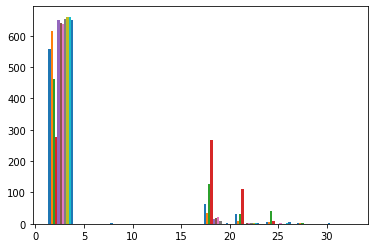

In [85]:
df_n = warehouse[y].to_numpy() #Преобразуем наш dataframe в массив NumPy
len_df = [[len(df_n[i,j]) for i in range(663)] for j in range(11)]
plt.hist(len_df)

In [86]:
max_len_id = np.max(len_df)#Получаем максимальное количество символов в ячейке
max_len_id

33

In [87]:
warehouse = warehouse.astype("U21")#Данные массива содержат как целые числа, так и строки, поэтому приравниваем данные к одному astype ("U21")

In [88]:
warehouse_ = warehouse.to_numpy()

In [89]:
[' '.join(x) for x in warehouse_]#Сцепляет строковые представления объектов из массива, перед преобразованием в индексы.

['100247567 подшипник 52206 $ $ $ подшипник koyo 52206 $ $ $ $ $ $ $',
 '100260213 подшипник 3206 $ $ $ подшипник koyo 3206 $ $ $ $ $ $ $',
 '100301277 подшипник k16х22х12 $ $ $ подшипник koyo k16х22х12 $ $ $ $ $ $ $',
 '100301278 подшипник k55х63х20 $ $ $ подшипник koyo k55х63х20 $ $ $ $ $ $ $',
 '100301279 подшипник rna4903 $ $ $ подшипник koyo rna4903 $ $ $ $ $ $ $',
 '100301360 подшипник 6406 подшипник skf 6406 подшипник fag 6406 подшипник snr 6406 подшипник koyo 6406 $ $ $ $ $ $ $',
 '100301361 подшипник 6201-2z $ $ $ подшипник koyo 6201-2z $ $ $ $ $ $ $',
 '100301362 подшипник 6407 подшипник skf 6407 подшипник fag 6407 подшипник snr 6407 подшипник koyo 6407 $ $ $ $ $ $ $',
 '100301363 подшипник na2020 $ $ $ подшипник koyo na2020 $ $ $ $ $ $ $',
 '100301364 подшипник na4913 $ $ $ подшипник koyo na4913 $ $ $ $ $ $ $',
 '100301365 подшипник na4924 $ $ $ подшипник koyo na4924 $ $ $ $ $ $ $',
 '100301366 подшипник 1201 подшипник skf 1201 e-tn9 подшипник fag 1201-tvh $ подшипник koyo 1

In [90]:
# Производим токенизацию текста, т.е. преобразуем буквы и цифры в индексы (в токены)
tokenizer = Tokenizer(filters = '', char_level=True) #, oov_token='<unk>' #Токенизация производится на уровне символов: char_level=True.
tokenizer.fit_on_texts([' '.join(x) for x in warehouse_]) # "Скармливаем" наши тексты, т. е. даём в обработку методу, который соберет словарь частотности
tokenizer.word_index #Вывод словаря частотности

{' ': 1,
 '$': 2,
 '(': 60,
 ')': 61,
 '*': 66,
 '+': 56,
 '-': 31,
 '.': 47,
 '/': 42,
 '0': 5,
 '1': 7,
 '2': 6,
 '3': 13,
 '4': 19,
 '5': 16,
 '6': 14,
 '7': 21,
 '8': 17,
 '9': 18,
 '=': 69,
 'a': 27,
 'b': 37,
 'c': 38,
 'd': 36,
 'e': 26,
 'f': 28,
 'g': 32,
 'h': 35,
 'i': 45,
 'j': 29,
 'k': 20,
 'l': 48,
 'm': 44,
 'n': 22,
 'o': 15,
 'p': 39,
 'q': 53,
 'r': 23,
 's': 25,
 't': 33,
 'u': 41,
 'v': 40,
 'w': 34,
 'x': 43,
 'y': 24,
 'z': 30,
 'а': 54,
 'в': 68,
 'г': 67,
 'д': 11,
 'е': 49,
 'з': 63,
 'и': 4,
 'й': 64,
 'к': 8,
 'л': 50,
 'м': 59,
 'н': 12,
 'о': 9,
 'п': 3,
 'р': 62,
 'с': 51,
 'т': 55,
 'у': 52,
 'х': 46,
 'ц': 65,
 'ш': 10,
 'ы': 57,
 'ь': 58}

In [91]:
len(tokenizer.word_index)

69

In [92]:
y_train = [] #Создаём список тренировочной выборки  

for i in y:
    temp = tokenizer.texts_to_sequences(warehouse[i])
    pad_temp = pad_sequences(temp, maxlen=max_len_id)
    y_train.append(pad_temp)
y_train = np.array(y_train)

In [93]:
#Формируем размеры y-train-массива
y_train.shape

(11, 663, 33)

In [94]:
y_train

array([[[ 0,  0,  0, ...,  0,  0,  2],
        [ 0,  0,  0, ...,  0,  0,  2],
        [ 0,  0,  0, ...,  0,  0,  2],
        ...,
        [ 0,  0,  0, ...,  0,  0,  2],
        [ 0,  0,  0, ...,  0,  0,  2],
        [ 0,  0,  0, ...,  0,  0,  2]],

       [[ 0,  0,  0, ...,  0,  0,  2],
        [ 0,  0,  0, ...,  0,  0,  2],
        [ 0,  0,  0, ...,  0,  0,  2],
        ...,
        [ 0,  0,  0, ...,  0,  0,  2],
        [ 0,  0,  0, ...,  0,  0,  2],
        [ 0,  0,  0, ...,  0,  0,  2]],

       [[ 0,  0,  0, ...,  0,  0,  2],
        [ 0,  0,  0, ...,  0,  0,  2],
        [ 0,  0,  0, ...,  0,  0,  2],
        ...,
        [ 0,  0,  0, ...,  0,  0,  2],
        [ 0,  0,  0, ...,  5, 13, 27],
        [ 0,  0,  0, ..., 13,  5, 19]],

       ...,

       [[ 0,  0,  0, ...,  0,  0,  2],
        [ 0,  0,  0, ...,  0,  0,  2],
        [ 0,  0,  0, ...,  0,  0,  2],
        ...,
        [ 0,  0,  0, ...,  0,  0,  2],
        [ 0,  0,  0, ...,  0,  0,  2],
        [ 0,  0,  0, ...,  0,  0

In [95]:
#Меняем оси местами, т.е. делаем сперва строки, затем колонки и количество символов в ячейках
y_train_ = np.transpose(y_train, (1,0,2)) 
y_train_.shape

(663, 11, 33)

In [96]:
#Преобрабатываем данные для модели, 11*33 (количество y-столбуов на количество символов в ячейке):
yTrainScaled = y_train_.reshape((y_train_.shape[0],len(y)*max_len_id))#11*33 
yTrainScaled.shape

(663, 363)

In [97]:
#Получаем то есть закодированные слова в числа
yTrainScaled

array([[0, 0, 0, ..., 0, 0, 2],
       [0, 0, 0, ..., 0, 0, 2],
       [0, 0, 0, ..., 0, 0, 2],
       ...,
       [0, 0, 0, ..., 0, 0, 2],
       [0, 0, 0, ..., 0, 0, 2],
       [0, 0, 0, ..., 0, 0, 2]], dtype=int32)

In [98]:

#Количество символов в ячейках по осям
xTrainScaled = tokenizer.texts_to_sequences(x.astype('U21'))
max_len_x = np.max([len(i) for i in xTrainScaled])
xTrainScaled = pad_sequences(xTrainScaled, maxlen=max_len_x)
xTrainC01 = tokenizer.texts_to_sequences(x1)
max_len_x1 = np.max([len(i) for i in xTrainC01])
xTrainC01 = pad_sequences(xTrainC01, maxlen=max_len_x1)
print(xTrainScaled.shape)
print(xTrainC01.shape)
print(yTrainScaled.shape)

(663, 9)
(663, 38)
(663, 363)


In [99]:
splitVal = 0.2 #Процент, который выделяем в проверочную выборку
valMask = np.random.sample(xTrainScaled.shape[0]) < splitVal #Создаём маску True-False для создания проверочной выборки

In [100]:
yTrainScaled = utils.to_categorical(yTrainScaled, len(tokenizer.word_index)) #Преобразует вектор класса (целые числа) в двоичную матрицу класса.
yTrainScaled.shape

(663, 363, 69)

Epoch 1/150
17/17 [==============================] - 3s 95ms/step - loss: 2.6499 - accuracy: 0.7314 - val_loss: 0.7943 - val_accuracy: 0.9336
Epoch 2/150
17/17 [==============================] - 1s 70ms/step - loss: 0.5386 - accuracy: 0.9305 - val_loss: 0.4258 - val_accuracy: 0.9359
Epoch 3/150
17/17 [==============================] - 1s 67ms/step - loss: 0.4041 - accuracy: 0.9319 - val_loss: 0.3760 - val_accuracy: 0.9341
Epoch 4/150
17/17 [==============================] - 1s 67ms/step - loss: 0.3546 - accuracy: 0.9319 - val_loss: 0.3409 - val_accuracy: 0.9391
Epoch 5/150
17/17 [==============================] - 1s 64ms/step - loss: 0.3222 - accuracy: 0.9351 - val_loss: 0.3148 - val_accuracy: 0.9398
Epoch 6/150
17/17 [==============================] - 1s 63ms/step - loss: 0.3030 - accuracy: 0.9378 - val_loss: 0.2994 - val_accuracy: 0.9405
Epoch 7/150
17/17 [==============================] - 1s 41ms/step - loss: 0.2883 - accuracy: 0.9362 - val_loss: 0.2849 - val_accuracy: 0.9397
Epoch 

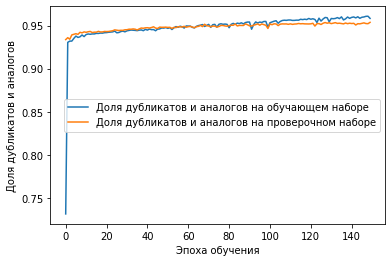

In [101]:
#Формируем модель, Dense сеть:
input1 = Input((xTrainScaled.shape[1],))
input2 = Input((xTrainC01.shape[1],))

x1 = Dense(15, activation="relu")(input1)
x2 = Dense(15, activation="relu")(input2)

x_c = Concatenate(axis=-1)([x1,x2])

x = Dense(15, activation='relu')(x_c)
x = Dense(yTrainScaled.shape[1]*len(tokenizer.word_index), activation='relu')(x)
x_r = Reshape((yTrainScaled.shape[1], len(tokenizer.word_index)))(x)

x = Dense(len(tokenizer.word_index), activation='softmax')(x_r)

model = Model((input1, input2), x)


model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit([xTrainScaled[~valMask], xTrainC01[~valMask]], 
                    yTrainScaled[~valMask], 
                    epochs=150, 
                    validation_data=([xTrainScaled[valMask], xTrainC01[valMask]], 
                    yTrainScaled[valMask]), 
                    verbose=1)
# строим график для отображения динамики обучения и точности предсказания сети
plt.plot(history.history['accuracy'], 
         label='Доля дубликатов и аналогов на обучающем наборе')
plt.plot(history.history['val_accuracy'], 
         label='Доля дубликатов и аналогов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля дубликатов и аналогов')
plt.legend()
plt.show()

**Визуализация модели. На вход подаём массив с символами X1, X2 и Y для предсказания.**

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 9)]          0           []                               
                                                                                                  
 input_6 (InputLayer)           [(None, 38)]         0           []                               
                                                                                                  
 dense_10 (Dense)               (None, 15)           150         ['input_5[0][0]']                
                                                                                                  
 dense_11 (Dense)               (None, 15)           585         ['input_6[0][0]']                
                                                                                            

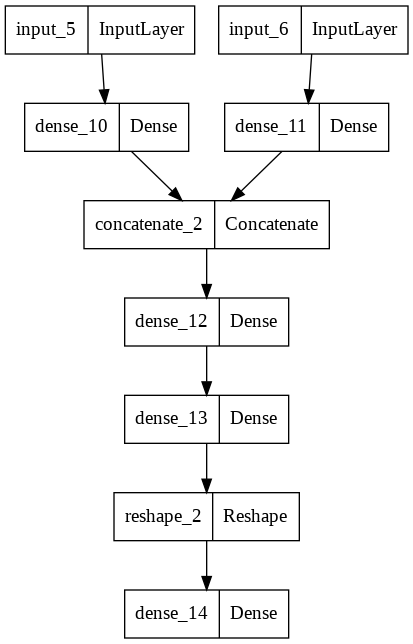

In [102]:
model.summary()
plot_model
plot_model(model, to_file='model.png')


**Для проверки предсказания используем функцию:**

In [103]:
#Преобразовываем индексы в текст по xTrain: 
pred_ = model.predict([xTrainScaled[valMask], xTrainC01[valMask]])
pred = np.argmax(pred_, axis=-1)
pred = pred.reshape(pred.shape[0], 11, 33) #Проводим reshape перед токенизацией
str_ = np.array([tokenizer.sequences_to_texts(i) for i in pred])#Преобразуем индексы в текст
rez = pd.DataFrame(str_, columns=y)
rez

,SKF,FAG,SNR,KOYO,EZO,NTN,NSK,RHP,ROLLWAY,TIMKEN,INA
0,$,$,$,п о д ш и п н и к k o y o n 2 0 $,$,$,$,$,$,$,$
1,$,$,$,д п и п к k o o k k x 2 5 / 1 0,$,$,$,$,$,$,$
2,п $,$,$,д ш и и к k o o y o 2 8 r 3 / 1 0,$,$,$,$,$,$,$
3,$,$,$,п о д ш и п н и к k o y o n 1 $,$,$,$,$,$,$,$
4,$,$,$,п о д ш и п н и к k o y o n a 4 $,$,$,$,$,$,$,$
...,...,...,...,...,...,...,...,...,...,...,...
145,$,$,$,о д ш и п н и к k o y o k k j 2 5 / 1 0,$,$,$,$,$,$,$
146,$,$,п о д ш и и к s n r 7 0 v d j $,$,$,$,$,$,$,$,$
147,$,$,$,п о д ш и п н и к k o y o 1 2,$,$,$,$,$,$,$
148,$,$,$,п о д ш и п н и к k o y o 6 1 2,$,$,$,$,$,$,$


In [104]:
#Преобразовываем индексы в текст по yTrain: 
pred_1 = np.argmax(yTrainScaled[valMask], axis=-1)
str_1 = pred_1.reshape(pred_1.shape[0],11,33)#Проводим reshape перед токенизацией
str_1 = np.array([tokenizer.sequences_to_texts(i) for i in str_1])#Преобразуем индексы в текст по каждой колонке
y_true = pd.DataFrame(str_1, columns=y)
y_true

,SKF,FAG,SNR,KOYO,EZO,NTN,NSK,RHP,ROLLWAY,TIMKEN,INA
0,$,$,$,п о д ш и п н и к k o y o 3 2 0 6,$,$,$,$,$,$,$
1,$,$,$,п о д ш и п н и к k o y o k 1 6 х 2 2 х 1 2,$,$,$,$,$,$,$
2,$,$,$,п о д ш и п н и к k o y o k 5 5 х 6 3 х 2 0,$,$,$,$,$,$,$
3,$,$,$,п о д ш и п н и к k o y o n a 2 0 2 0,$,$,$,$,$,$,$
4,$,$,$,п о д ш и п н и к k o y o n a 4 9 2 4,$,$,$,$,$,$,$
...,...,...,...,...,...,...,...,...,...,...,...
145,$,$,$,п о д ш и п н и к k o y o n k j 6 0 / 2 5,$,$,$,$,$,$,$
146,$,$,п о д ш и п н и к s n r 7 0 1 0 h v d b j 8 4,$,$,$,$,$,$,$,$
147,$,$,$,п о д ш и п н и к k o y o 3 2 1 0,$,$,$,$,$,$,$
148,$,$,$,п о д ш и п н и к k o y o 3 2 1 1,$,$,$,$,$,$,$


In [105]:
#Сконтенерируем все строчки в одну
' '.join(str_[0])


'$ $ $ п о д ш и п н и к   k o y o   n 2 0 $ $ $ $ $ $ $ $'

In [106]:
#Сконтенерируем все строчки в одну по yTrain
' '.join(str_1[0])

'$ $ $ п о д ш и п н и к   k o y o   3 2 0 6 $ $ $ $ $ $ $'

In [107]:
!pip -q install jiwer #репозиторий для автоматической оценки сходства между двумя строками

In [108]:
from jiwer import wer # модуль метрики качества в распознавании речи

In [109]:
#Подсчёт средней (mean) и медианы(median) по потерям(loss) 
loss = []
for i in range(len(str_1)):
    loss.append(wer(' '.join(str_[i]).lower(), ' '.join(str_1[i]).lower()))#Подсчёт результата с помощью Wer, между Str_1 фактом (True) и предсказанием Str_

loss = np.array(loss)
print('Loss mean:', loss.mean())
print('Loss median:', np.median(loss))

# было mean 2.1079671785554135
# было median 1.6363636363636365

Loss mean: 0.5270854366288423
Loss median: 0.301994301994302


In [110]:
#Выведем сравнительные строки между y-train True и predict
k = 0
v = 0
for i, s_ in enumerate(str_1):
        for j, s in enumerate(s_):
            if s != "$":
                print('y_train:     ', s)
                v +=1
                if str_[i][j] != '$':
                    k+-1
                print('pred:        ', str_[i][j])
                print()

            
                
 

y_train:      п о д ш и п н и к   k o y o   3 2 0 6
pred:         п о д ш и п н и к   k o y o   n 2 0 $

y_train:      п о д ш и п н и к   k o y o   k 1 6 х 2 2 х 1 2
pred:         д п и п к k   o o   k k x 2 5 / 1 0

y_train:      п о д ш и п н и к   k o y o   k 5 5 х 6 3 х 2 0
pred:         д ш и и к k o o y o   2 8 r 3 / 1 0

y_train:      п о д ш и п н и к   k o y o   n a 2 0 2 0
pred:         п о д ш и п н и к   k o y o   n 1 $

y_train:      п о д ш и п н и к   k o y o   n a 4 9 2 4
pred:         п о д ш и п н и к   k o y o   n a 4 $

y_train:      п о д ш и п н и к   s k f   3 2 0 5 a
pred:         о ш и $

y_train:      п о д ш и п н и к   f a g   3 2 0 5 - b d - t v h
pred:         h

y_train:      п о д ш и п н и к   s n r   3 2 0 5 b
pred:         $

y_train:      п о д ш и п н и к   k o y o   3 2 0 5
pred:         и и 6 0 $

y_train:      п о д ш и п н и к   n t n   5 2 0 5 s
pred:         о д ш п к   0 6

y_train:      п о д ш и п н и к   n s k   3 2 0 5 b t n g
pred:     